# Сlassification of architectural styles

In [ ]:
%%capture test
!pip install -U albumentations

In [ ]:
%%capture test
!pip install opencv-contrib-python==4.5.5.62

In [ ]:
%%capture test
!pip install timm

In [ ]:
import os
import shutil
from pathlib import Path

import numpy as np
import random

import cv2
from tqdm import *
from tqdm.notebook import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from albumentations.pytorch import ToTensorV2
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import timm

import albumentations as A
import albumentations.pytorch as AP

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Resize, RandomCrop,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomScale, RandomGridShuffle,
    RandomContrast, RandomGamma, RandomBrightness, CenterCrop, VerticalFlip, ColorJitter,
    ChannelShuffle, InvertImg, RGBShift, ElasticTransform, Equalize, RandomResizedCrop, ChannelDropout
)

import matplotlib.pyplot as plt
%matplotlib inline

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# ====================================================
# CFG - класс с параметрами нашего эксперимента
# ====================================================

class CFG:

    num_workers=2
    model_name='resnet50' # ['resnext101_32x8d', 'inception_v3', 'densenet169', 'efficientnet_b0']
    size=224
    scheduler='StepLR' # ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=30
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=8
    seed=42

    api = ""
    project = ""
    entity = ""

In [ ]:
# СFG в dict

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [1]:
# Загружаем датасет

%%capture test
! git clone --branch small https://github.com/msand67/ADrepo

Для успешного решения данной задачи нам потребуется 2 новые библиотеки: **Albumentations** и **PyTorch image models (timm)**.

## Аугментация


In [ ]:
data_transforms = {
    'train': A.Compose([
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomFog(p=0.3, ),
        # добавляем дождь. Что естественно для фото зданий
        A.RandomRain(p=0.2, blur_value=3),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}

Поскольку у нас нестандартные аугментации, нам придется несколько переписать стандартный модуль Dataset.

In [ ]:
# ====================================================
# MakeDataset - класс для создания датасета
# ====================================================

class MakeDataset(torch.utils.data.Dataset):
    def __init__(self, files, transform=None):
        super().__init__()
        self.files = files
        self.labels = [path.parent.name for path in self.files]
        self.len_ = len(self.files)
        self.transform = transform
        self.classes = ['American Craftsman', 'Art Deco', 'Art Nouveau', 'Baroque', 'Beaux-Arts', 'Georgian',
                        'Japanese Traditional', 'Queen Annes', 'Russian Revival', 'Tudor Revival']

    def __len__(self): # функция определения размера датасета
        return self.len_

    def __getitem__(self, index): # функция чтения и обработки каждой картинки
        image = cv2.imread(f'{self.files[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = self.labels[index]
        for i in range(len(self.classes)):
          if label == self.classes[i]:
            y = i

        return image, y

In [ ]:
TRAIN_DIR = Path("/content/ADrepo/75_set/Training_Set")
VAL_DIR = Path("/content/ADrepo/75_set/Testing_Set")



# рекурсивно обойдем все папки с изображениями
train_files = sorted(list(TRAIN_DIR.rglob('*.JPG')))
val_files = sorted(list(VAL_DIR.rglob('*.JPG')))

In [ ]:
train_dataset = MakeDataset(train_files, transform=data_transforms['train'])
val_dataset = MakeDataset(val_files, transform=data_transforms['val'])

In [ ]:
# Функция отрисовки изображений

def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Посмотрим, как выглядят наши картинки уже после применения к ним аугментаций.

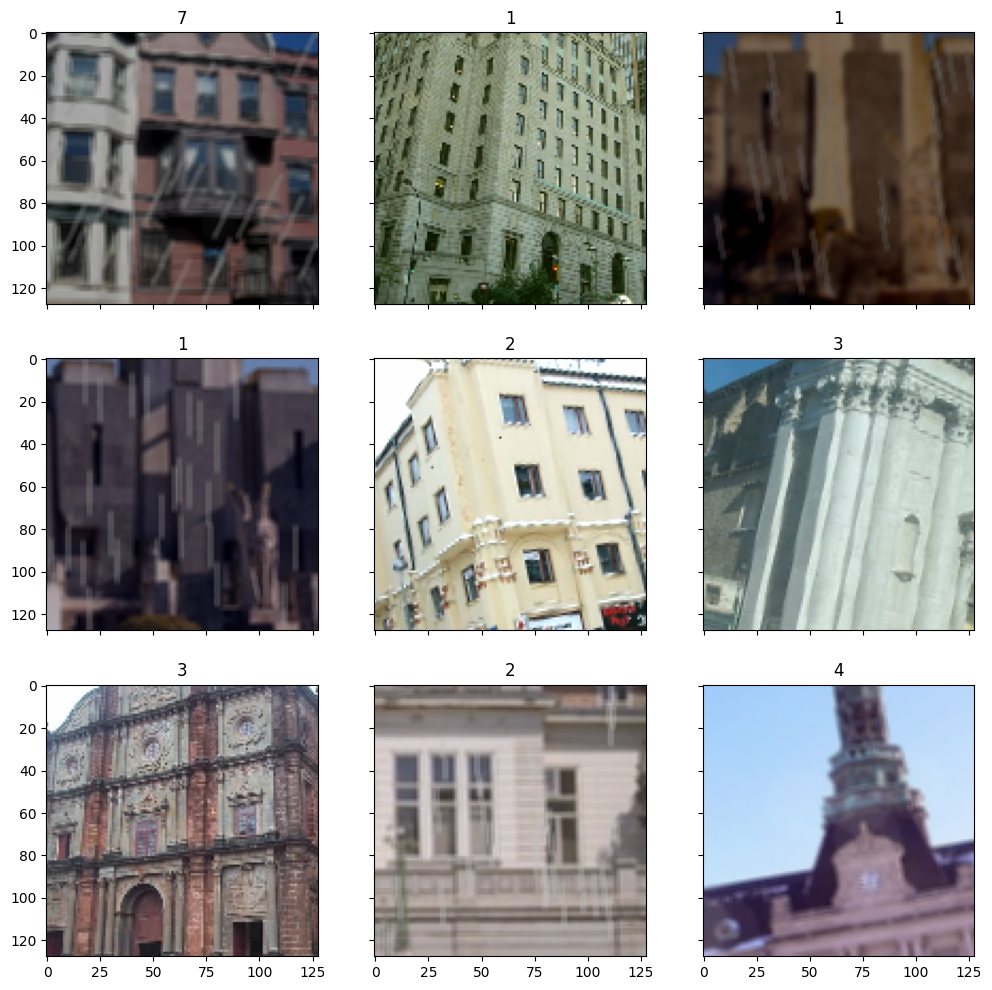

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_img = int(np.random.uniform(0,len(train_files)))
    im_val, label = train_dataset[random_img]
    img_label = label
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
BATCH_SIZE = 30
dataloader = {'train': torch.utils.data.DataLoader(
                    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),

              'val': torch.utils.data.DataLoader(
                    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)}# ВАШ КОД ЗДЕСЬ

print('Train and Valid datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(dataloader['train']), len(dataloader['train'])))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(dataloader['val']), len(dataloader['val'])))

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train           5         5
Valid           3         3


In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Функция обучения и инференса модели

def train_val_model(model, loss, optimizer, scheduler, num_epochs):

    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    best_acc = 0.
    progress = tqdm(range(num_epochs), desc='Epoch:')


    seed_everything(CFG.seed)

    for epoch in progress:
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="\n")
        for phase in ['train', 'val']:
            if phase == 'train':

                model.train()
            else:
                model.eval()
            running_loss = 0.
            running_acc = 0.

            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader[phase]):
                inputs =  inputs.to(DEVICE)
                labels =  labels.to(DEVICE)

                optimizer.zero_grad()# Обнуляем градиент,чтобы он не накапливался

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':

                        loss_value.backward()
                        optimizer.step()# Считаем градиент
                         # Считаем шаг градиентного спуска

                # Статистика
                running_loss += loss_value.item() # Считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()
            epoch_loss = running_loss / len(dataloader[phase])
            epoch_acc = running_acc / len(dataloader[phase])


            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc), end="\n")

            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
              torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')

            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

    return model, loss_hist, acc_hist

In [ ]:
# ====================================================
# My_Net - класс для создания модели
# ====================================================

class My_Net(torch.nn.Module):
    def __init__(self, model_name='resnest101e', pretrained=False, effnet=False, value=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)


        for param in self.model.parameters():
          param.requires_grad = False


        if effnet: # Для EfficientNet есть небольшие отличия в названии слоев
          fc_inputs = self.model.classifier.in_features,
          #self.model.classifier = nn.Identity(),
          self.model.classifier = torch.nn.Sequential(
              torch.nn.Linear(fc_inputs[0], 1024),
              torch.nn.ReLU(),
              torch.nn.Linear(1024, 256),
              torch.nn.ReLU(),
              torch.nn.Linear(256, 10))
        else:
          fc_features  = self.model.fc.in_features,
          print(fc_features),
          #self.model.fc = nn.Linear(in_features=fc_features[0], out_features=10)
          self.model.fc = torch.nn.Sequential(
              torch.nn.Linear(fc_features[0], 1024),
              torch.nn.ReLU(),
              torch.nn.Linear(1024, 256),
              torch.nn.ReLU(),
              torch.nn.Linear(256, 10))

          #nn.Sequential([
          #('fc1', nn.Linear(in_features=fc_features[0], out_features=1024)),
          #('relu1', nn.ReLU()),
          #('fc2', nn.Linear(1024, 256)),
          #('relu2', nn.ReLU()),
          #('fc2', nn.Linear(256, 10))])

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:

model2 = timm.create_model('tf_efficientnet_b0', pretrained=True)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
model = My_Net(CFG.model_name, pretrained=True, effnet=False, value=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем Loss функцию
# В данном случае - это кросс-энтропия
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска AdamW
optimizer = torch.optim.AdamW(params=model.model.fc.parameters(), lr=1e-4)

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

(2048,)


Итак, поехали!

In [ ]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, CFG.epochs)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.29 accuracy: 0.20


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.29 accuracy: 0.18
Epoch 1 - Save Best Accuracy: 0.18 Model

Epoch 2/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.28 accuracy: 0.12


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.26 accuracy: 0.22
Epoch 2 - Save Best Accuracy: 0.22 Model

Epoch 3/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.25 accuracy: 0.18


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.25 accuracy: 0.18
Epoch 4/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.21 accuracy: 0.27


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.22 accuracy: 0.31
Epoch 4 - Save Best Accuracy: 0.31 Model

Epoch 5/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.19 accuracy: 0.24


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.20 accuracy: 0.24
Epoch 6/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.15 accuracy: 0.31


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.17 accuracy: 0.30
Epoch 7/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.11 accuracy: 0.30


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.11 accuracy: 0.29
Epoch 8/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.10 accuracy: 0.28


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.15 accuracy: 0.18
Epoch 9/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.09 accuracy: 0.27


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.12 accuracy: 0.28
Epoch 10/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.07 accuracy: 0.27


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.09 accuracy: 0.23
Epoch 11/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.99 accuracy: 0.35


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.08 accuracy: 0.20
Epoch 12/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.02 accuracy: 0.27


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.03 accuracy: 0.23
Epoch 13/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.93 accuracy: 0.36


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.99 accuracy: 0.26
Epoch 14/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.93 accuracy: 0.29


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.94 accuracy: 0.31
Epoch 14 - Save Best Accuracy: 0.31 Model

Epoch 15/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.96 accuracy: 0.37


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.97 accuracy: 0.34
Epoch 15 - Save Best Accuracy: 0.34 Model

Epoch 16/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.89 accuracy: 0.38


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.85 accuracy: 0.42
Epoch 16 - Save Best Accuracy: 0.42 Model

Epoch 17/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.86 accuracy: 0.38


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.98 accuracy: 0.33
Epoch 18/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.80 accuracy: 0.55


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.90 accuracy: 0.44
Epoch 18 - Save Best Accuracy: 0.44 Model

Epoch 19/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.70 accuracy: 0.53


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.82 accuracy: 0.44
Epoch 20/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.77 accuracy: 0.43


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.85 accuracy: 0.40
Epoch 21/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.76 accuracy: 0.39


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.91 accuracy: 0.27
Epoch 22/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.70 accuracy: 0.41


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.73 accuracy: 0.43
Epoch 23/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.66 accuracy: 0.47


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.74 accuracy: 0.43
Epoch 24/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.60 accuracy: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.71 accuracy: 0.50
Epoch 24 - Save Best Accuracy: 0.50 Model

Epoch 25/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.53 accuracy: 0.62


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.75 accuracy: 0.46
Epoch 26/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.54 accuracy: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.71 accuracy: 0.46
Epoch 27/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.40 accuracy: 0.63


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.54 accuracy: 0.54
Epoch 27 - Save Best Accuracy: 0.54 Model

Epoch 28/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.44 accuracy: 0.57


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.74 accuracy: 0.46
Epoch 29/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.41 accuracy: 0.61


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.56 accuracy: 0.47
Epoch 30/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.57 accuracy: 0.49


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.59 accuracy: 0.38


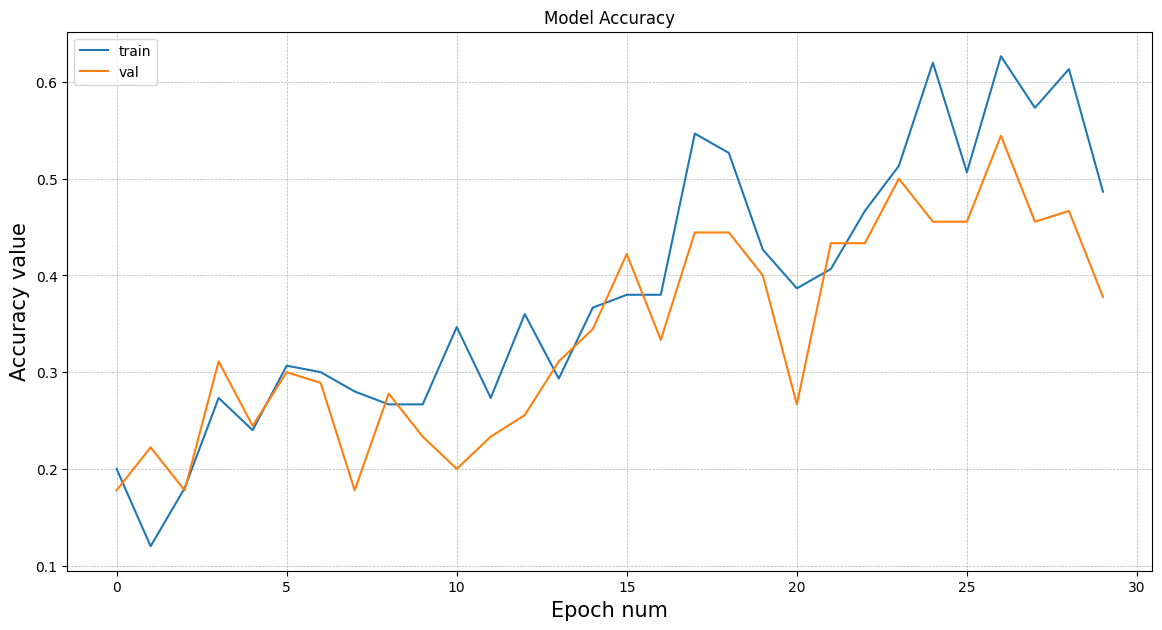

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Мало данных, и "тяжелая" аугментация

In [ ]:
model = My_Net('tf_efficientnet_b0', pretrained=True, effnet=True, value=False) # Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этой модели на датасете ImageNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем Loss функцию
# В данном случае - это кросс-энтропия
loss = torch.nn.CrossEntropyLoss()# ВАШ КОД ЗДЕСЬ
# Метод градиентного спуска AdamW
optimizer = torch.optim.AdamW(params=model.model.classifier.parameters(), lr=1e-4) # ВАШ КОД ЗДЕСЬ

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

In [ ]:
model2, loss2, acc2 = train_val_model(model, loss, optimizer, scheduler, CFG.epochs)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.30 accuracy: 0.05


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.29 accuracy: 0.22
Epoch 1 - Save Best Accuracy: 0.22 Model

Epoch 2/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.27 accuracy: 0.15


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.27 accuracy: 0.17
Epoch 3/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.25 accuracy: 0.23


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.25 accuracy: 0.23
Epoch 3 - Save Best Accuracy: 0.23 Model

Epoch 4/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.21 accuracy: 0.29


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.24 accuracy: 0.19
Epoch 5/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.20 accuracy: 0.29


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.21 accuracy: 0.13
Epoch 6/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.16 accuracy: 0.37


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.20 accuracy: 0.26
Epoch 6 - Save Best Accuracy: 0.26 Model

Epoch 7/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.11 accuracy: 0.35


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.15 accuracy: 0.30
Epoch 7 - Save Best Accuracy: 0.30 Model

Epoch 8/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.10 accuracy: 0.34


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.19 accuracy: 0.19
Epoch 9/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.11 accuracy: 0.31


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.15 accuracy: 0.30
Epoch 10/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.08 accuracy: 0.34


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.12 accuracy: 0.28
Epoch 11/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.00 accuracy: 0.45


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.14 accuracy: 0.29
Epoch 12/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.00 accuracy: 0.44


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.10 accuracy: 0.39
Epoch 12 - Save Best Accuracy: 0.39 Model

Epoch 13/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.91 accuracy: 0.45


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.03 accuracy: 0.31
Epoch 14/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.92 accuracy: 0.36


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.96 accuracy: 0.43
Epoch 14 - Save Best Accuracy: 0.43 Model

Epoch 15/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.89 accuracy: 0.43


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.97 accuracy: 0.43
Epoch 16/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.86 accuracy: 0.45


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.91 accuracy: 0.46
Epoch 16 - Save Best Accuracy: 0.46 Model

Epoch 17/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.79 accuracy: 0.47


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 2.04 accuracy: 0.41
Epoch 18/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.73 accuracy: 0.55


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.95 accuracy: 0.48
Epoch 18 - Save Best Accuracy: 0.48 Model

Epoch 19/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.65 accuracy: 0.62


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.92 accuracy: 0.49
Epoch 19 - Save Best Accuracy: 0.49 Model

Epoch 20/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.66 accuracy: 0.53


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.84 accuracy: 0.49
Epoch 20 - Save Best Accuracy: 0.49 Model

Epoch 21/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.74 accuracy: 0.45


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.83 accuracy: 0.48
Epoch 22/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.61 accuracy: 0.55


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.70 accuracy: 0.56
Epoch 22 - Save Best Accuracy: 0.56 Model

Epoch 23/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.59 accuracy: 0.51


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.74 accuracy: 0.51
Epoch 24/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.53 accuracy: 0.61


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.74 accuracy: 0.52
Epoch 25/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.39 accuracy: 0.69


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.64 accuracy: 0.56
Epoch 26/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.39 accuracy: 0.63


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.65 accuracy: 0.51
Epoch 27/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.32 accuracy: 0.62


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.53 accuracy: 0.60
Epoch 27 - Save Best Accuracy: 0.60 Model

Epoch 28/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.34 accuracy: 0.67


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.64 accuracy: 0.44
Epoch 29/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.29 accuracy: 0.62


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.53 accuracy: 0.50
Epoch 30/30:


  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 1.32 accuracy: 0.62


  0%|          | 0/3 [00:00<?, ?it/s]

val loss: 1.60 accuracy: 0.44


In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model2 Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')